# Задание: повторить алгоритм рекомендации из статьи или из репозитория https://github.com/microsoft/recommenders. На выходе должен быть colab с пояснениями.

В этом коллабе рассматривается построение ***гибридной рекомендательной модели на основе матричной факторизации*** (разложения матрицы взаимодействия пользователя с элементом на произведение матриц меньшей размерности). Модель рассматривается на примере датасета MovieLens.

https://github.com/microsoft/recommenders/blob/master/examples/02_model_hybrid/lightfm_deep_dive.ipynb

# **Предподсылки:**

В целом, большинство моделей рекомендаций можно разделить на две категории: content-based модели (на основе контента) и модели коллаборативной фильтрации. 

Выбор между двумя моделями во многом зависит от наличия данных. Например, модель коллаборативной фильтрации обычно применяется и эффективна, когда для группы пользователей и объектов было записано достаточное количество оценок / отзывов. Однако, если рейтинги отсутствуют, можно использовать модель на основе контента при условии, что доступны метаданные пользователей и объектов (н-р, фильмов). Это также общий подход к решению проблем холодного старта, когда недостаточно зафиксированных совместных взаимодействий, доступных для моделирования новых пользователей и / или объектов.

Ввиду вышеупомянутых проблем был выдвинут ряд предложений по решению проблем холодного старта путем комбинирования подходов к фильтрации на основе контента и коллаборативной фильтрации. Гибридная модель на основе матричной факторизации - одно из предложенных решений.

# **LightFM Package**

LightFM - реализация на Питоне гибридных алгоритмов рекомендаций как с неявной, так и с явной обратной связью. Эта гибридная  модель представляет пользователей и объекты как линейные комбинации скрытых факторов, характеризующих данный контент. Модель изучает эмбеддинги или скрытые представления пользователей и объектов таким образом, что она кодирует предпочтения пользователей по объектам. Эти представления дают "баллы" (scores) по каждому объекту для данного пользователя; объекты, получившие высокие оценки, с большей вероятностью будут интересны пользователю.

Эмбеддинги пользователей и объектов оцениваются для каждого признака, а затем эти признаки складываются вместе. 
Например, для пользователя i модель извлекает i-ю строку матрицы признаков, чтобы найти признаки с ненулевым весом. Далее, чтобы получить представление пользователя вычисляем сумму эмбеддингов всех признаков, умноженных на их веса (weights). 
Представления объектов рассчитываются аналогичным образом.

# **Часть 1.** Рекомендация фильмов с LightFM с использованием только явной обратной связи. 

*1.1 Импортируем библиотеки.*

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation

# импортируем метрики оценки LightFM
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k

# импортируем метрики оценки из этого репозитория
from reco_utils.evaluation.python_evaluation import (
    precision_at_k, recall_at_k)

from reco_utils.common.timer import Timer
from reco_utils.dataset import movielens
from reco_utils.recommender.lightfm.lightfm_utils import (
    track_model_metrics, prepare_test_df, prepare_all_predictions,
    compare_metric, similar_users, similar_items)

*1.2 Задаем переменные.*

In [ ]:
# выбираем размер MovieLens
MOVIELENS_DATA_SIZE = '100k'

# количество рекомендаций по умолчанию
K = 10
# размер тестовой выборки
TEST_PERCENTAGE = 0.25
# скорость обучения модели
LEARNING_RATE = 0.25
# количество скрытых факторов
NO_COMPONENTS = 20
# количество эпох обучения модели
NO_EPOCHS = 20
# количество потоков обучения
NO_THREADS = 32
# регуляризация для признаков объектов и пользователей
ITEM_ALPHA=1e-6
USER_ALPHA=1e-6

# число (seed) для генератора псевдослучайных чисел
SEEDNO = 42

*1.3 Получение данных.*

In [ ]:
data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    genres_col='genre',
    header=["userID", "itemID", "rating"])

data.sample(5)

100%|██████████| 4.81k/4.81k [00:03<00:00, 1.45kKB/s]


,userID,itemID,rating,genre
97659,355,1175,5.0,Romance
92378,519,878,5.0,Children's|Comedy|Mystery
39656,537,212,3.0,Drama
3760,882,1,5.0,Animation|Children's|Comedy
66470,5,447,3.0,Horror


*1.4 Подготовка данных.*

В Dataset будет храниться матрица взаимодействий.

In [ ]:
dataset = Dataset()

Метод fit создает мэппинг (определение соответствия данных между потенциально различными семантиками одного объекта) идентификаторов пользователя / объекта.

In [ ]:
dataset.fit(users=data['userID'], 
            items=data['itemID'])

# проверяем количество уникальных пользователей и объектов
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 943, num_topics: 1682.


Далее строим матрицу взаимодействий. Метод build_interactions возвращает 2 разреженные матрицы, а именно матрицы взаимодействий и весов.

In [ ]:
(interactions, weights) = dataset.build_interactions(data.iloc[:, 0:3].values)

LightFM работает несколько иначе по сравнению с другими моделями, так как ожидает, что обучающая и тестовая выборки будут иметь одинаковые размеры. Следовательно, обычное разделение данных не подходит. 

В LightFM включен метод cross_validation.random_train_test_split для разделения данных на два непересекающихся набора для обучения и тестирования.

In [ ]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEEDNO))

Проверяем размер выборок.

In [ ]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (943, 1682)
Shape of test interactions: (943, 1682)


*1.5 Обучение модели.*

В качестве функции потерь (loss) Light FM использует WARP (weighted Approximate-Rank Pairwise). Эта функция потерь лучше других показывает себя в задачах ранжирования. Она работает с тройками (user, positive_item, negative_item) и имеет одну очень важную особенность — выбор негативных примеров происходит не случайно, а таким образом, чтобы выбранные негативные примеры «ломали» текущее ранжирование модели, т.е. были выше, чем позитивный пример. Этот подход рекомендуется при наличии только положительных взаимодействий.

In [ ]:
model1 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE,                 
                 random_state=np.random.RandomState(SEEDNO))

model1.fit(interactions=train_interactions,
          epochs=NO_EPOCHS);

*1.6 Подготовка данных для оценки модели.*

Прежде чем мы сможем оценить модель, нужно обработать данные для того, чтобы получить их формате, совместимом с существующими методами оценки в этом репозитории.

Во-первых, нужно извлечь индексы обучающих и тестовых данных из метода lightfm.cross_validation следующим образом:

In [ ]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, interactions.col, interactions.data, 
    random_state=np.random.RandomState(SEEDNO))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

Затем мэппинг между внутренним и внешним представлением пользователя и объекта извлекается следующим образом:

In [ ]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

Создаем тестовую dataframe.

In [ ]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  
time_reco1 = test_time.interval

Took 2.1 seconds for prepare and predict test data.


In [ ]:
test_df.sample(5)

,userID,itemID,rating
22989,334,1074,2.0
11409,747,664,2.0
24134,115,172,4.0
495,622,1,3.0
6673,777,168,5.0


Теперь получаем прогнозы по рекомендациям.

In [ ]:
with Timer() as test_time:
    all_predictions = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions,
                                              model=model1, 
                                              num_threads=NO_THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

Took 528.2 seconds for prepare and predict all data.


In [ ]:
all_predictions.sample(5)

,userID,itemID,prediction
1471603,132,1462,-108.912407
525255,820,835,17.957056
638079,166,1240,75.742126
263978,297,362,-58.599857
90527,129,709,-24.803879


Здесь следует обратить внимание, что ***значения переменной prediction используются только для целей ранжирования,*** сама переменная не имеет здесь какой-то интерпретации.

*1.7 Оценка модели.*

Производительность модели будет оценена с использованием метрик **Precision@K** (точность на K объектов) и **Recall@K** (полнота на K объектов). Чтобы гарантировать точность, результаты метрик из этого репозитория также сравниваются с результатами, вычисленными с помощью собственных методов оценки LightFM.

In [ ]:
with Timer() as test_time:
    eval_precision = precision_at_k(rating_true=test_df, 
                                rating_pred=all_predictions, k=K)
    eval_recall = recall_at_k(test_df, all_predictions, k=K)
time_reco3 = test_time.interval

with Timer() as test_time:
    eval_precision_lfm = lightfm_prec_at_k(model1, test_interactions, 
                                           train_interactions, k=K).mean()
    eval_recall_lfm = lightfm_recall_at_k(model1, test_interactions, 
                                          train_interactions, k=K).mean()
time_lfm = test_time.interval
    
print(
    "------ Using Repo's evaluation methods ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using LightFM evaluation methods ------",
    f"Precision@K:\t{eval_precision_lfm:.6f}",
    f"Recall@K:\t{eval_recall_lfm:.6f}", 
    sep='\n')

------ Using Repo's evaluation methods ------
Precision@K:	0.131601
Recall@K:	0.038056

------ Using LightFM evaluation methods ------
Precision@K:	0.131601
Recall@K:	0.038056


# Часть 2. Рекомендация фильмов с LightFM с использованием явной обратной связи и дополнительных признаков пользователей и объектов.

Поскольку LightFM был разработан для включения метаданных как пользователя, так и объекта, модель может быть расширена за счет использования дополнительных признаков, таких как жанры фильмов и род деятельности пользователей.

*2.1 Извлекаем жанры.*

Как метаданные фильмов здесь используются их жанры. Поскольку жанры уже были загружены во время первоначального импорта данных, их можно обработать напрямую следующим образом:

In [ ]:
#разделяем жанры по вертикальной черте
movie_genre = [x.split('|') for x in data['genre']]

# находим все уникальные жанры
all_movie_genre = sorted(list(set(itertools.chain.from_iterable(movie_genre))))
all_movie_genre

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'unknown']

*2.2 Подготовка данных.*

Дополнительные признаки пользователей могут быть включены в модель. Здесь указан только род занятий каждого пользователя, но список признаков можно легко расширить. Пользовательские признаки могут быть получены непосредственно с веб-сайта grouplens и объединены с существующими данными следующим образом:

In [ ]:
user_feature_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.user'
user_data = pd.read_table(user_feature_URL, 
              sep='|', header=None)
user_data.columns = ['userID','age','gender','occupation','zipcode']

#объединяем признаки пользователей с уже существующими данными
new_data = data.merge(user_data[['userID','occupation']], left_on='userID', right_on='userID')
new_data.sample(5)

,userID,itemID,rating,genre,occupation
73219,42,603,4.0,Mystery|Thriller,administrator
23184,421,197,3.0,Drama|Romance,programmer
53601,130,219,5.0,Horror,none
92696,496,135,2.0,Drama|Mystery|Sci-Fi|Thriller,student
33796,458,129,4.0,Crime|Drama|Romance|Thriller,technician


In [ ]:
# составляем список уникальных occupation
all_occupations = sorted(list(set(new_data['occupation'])))

Аналогично предыдущей модели, преобразуем данные и создаем мэппинг идентификаторов пользователя / объекта с помощью метода fit.

In [ ]:
dataset2 = Dataset()
dataset2.fit(data['userID'], 
            data['itemID'], 
            item_features=all_movie_genre,
            user_features=all_occupations)

Жанры фильмов преобразуем в матрицу признаков объектов с помощью метода build_item_features следующим образом:

In [ ]:
item_features = dataset2.build_item_features(
    (x, y) for x,y in zip(data.itemID, movie_genre))

Аналогично преобразуем профессии пользователей в матрицу признаков пользователей.

In [ ]:
user_features = dataset2.build_user_features(
    (x, [y]) for x,y in zip(new_data.userID, new_data['occupation']))

Далее строим матрицу взаимодействий и разделяем ее на обучающую и тестовую выборку следующим образом:

In [ ]:
(interactions2, weights2) = dataset2.build_interactions(data.iloc[:, 0:3].values)

train_interactions2, test_interactions2 = cross_validation.random_train_test_split(
    interactions2, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEEDNO))

Параметры второй модели будут аналогичны первой модели для облегчения их сравнения.

Производительность модели в каждую эпоху также отслеживается теми же показателями, что и раньше.

In [ ]:
model2 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE, 
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEEDNO))

In [ ]:
model2.fit(interactions=train_interactions2,
           user_features=user_features,
           item_features=item_features,
           epochs=NO_EPOCHS);

*2.3 Подготовка данных для оценки модели.*

Как и в предыдущей модели, данные сначала необходимо обработать.
Во-первых, нужно извлечь индексы обучающих и тестовых данных из метода lightfm.cross_validation следующим образом:

In [ ]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions2.row, interactions2.col, interactions2.data, 
    random_state=np.random.RandomState(SEEDNO))

Затем мэппинг между внутренним и внешним представлением пользователя и объекта извлекается следующим образом:

In [ ]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset2.mapping()

Во-вторых, строим тестовую dataframe.

In [ ]:
with Timer() as test_time:
    test_df2 = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights2)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")

Took 2.0 seconds for prepare and predict test data.


И получаем прогнозы по рекомендациям.

In [ ]:
with Timer() as test_time:
    all_predictions2 = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions2,
                                               user_features=user_features,
                                               item_features=item_features,
                                               model=model2,
                                               num_threads=NO_THREADS)

print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")

Took 261.2 seconds for prepare and predict all data.


# Часть 3. Оценка и сравнение моделей.

Прогнозируемая производительность новой модели может быть вычислена и сравнена с предыдущей моделью (в которой использовалась только явная оценка) следующим образом:

In [ ]:
eval_precision2 = precision_at_k(rating_true=test_df2, 
                                rating_pred=all_predictions2, k=K)
eval_recall2 = recall_at_k(test_df2, all_predictions2, k=K)

print(
    "------ Using only explicit ratings ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using both implicit and explicit ratings ------",
    f"Precision@K:\t{eval_precision2:.6f}",
    f"Recall@K:\t{eval_recall2:.6f}",
    sep='\n')

------ Using only explicit ratings ------
Precision@K:	0.131601
Recall@K:	0.038056

------ Using both implicit and explicit ratings ------
Precision@K:	0.146766
Recall@K:	0.055104


Для большей наглядности показатели обучения и производительности моделей можно визуализировать.

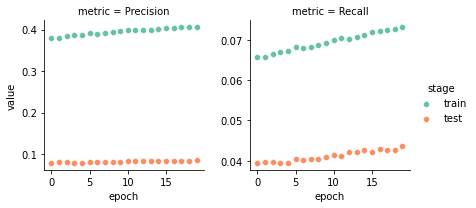

In [ ]:
#первая модель

output1, _ = track_model_metrics(model=model1, train_interactions=train_interactions, 
                              test_interactions=test_interactions, k=K,
                              no_epochs=NO_EPOCHS, no_threads=NO_THREADS)

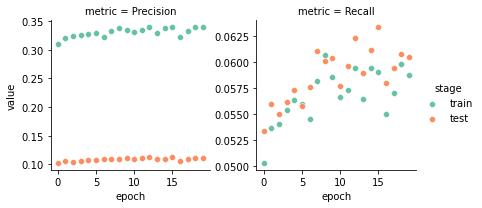

In [ ]:
#вторая модель

output2, _ = track_model_metrics(model=model2, train_interactions=train_interactions2, 
                              test_interactions=test_interactions2, k=K,
                              no_epochs=NO_EPOCHS, no_threads=NO_THREADS, 
                              item_features=item_features,
                              user_features=user_features)

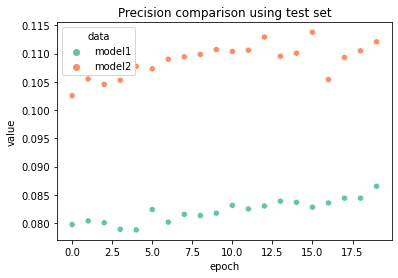

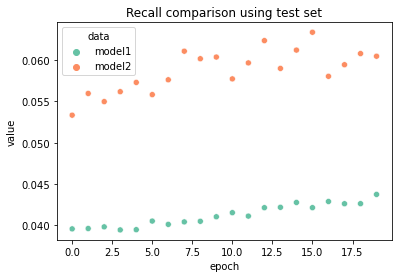

In [ ]:
for i in ['Precision', 'Recall']:
    sns.set_palette("Set2")
    plt.figure()
    sns.scatterplot(x="epoch", y="value", hue='data',
                data=compare_metric(df_list = [output1, output2], metric=i)
               ).set_title(f'{i} comparison using test set');

Ссылаясь на приведенные выше цифры, довольно очевидно, что количество эпох слишком мало, поскольку характеристики модели не стабилизировались. Следует выбирать иное количество эпох и другие гиперпараметры для улучшение производительности модели.

Однако, интересно, что модель 2 (с использованием как неявных, так и явных данных) работает стабильно лучше, чем модель 1 (с использованием только явных оценок), что подчеркивает преимущества включения таких дополнительных признаков в модель.

# Часть 4. Похожие пользователи и объекты.

Также мы можем получить схожих пользователей с помощью метода get_user_presentations следующим образом:

In [ ]:
_, user_embeddings = model2.get_user_representations(features=user_features)
user_embeddings

array([[-2.812179  ,  1.2222148 ,  4.953264  , ..., -3.3555129 ,
         1.6758035 , -2.2008545 ],
       [-5.561155  ,  0.9935793 ,  4.898535  , ..., -2.4852693 ,
         2.6707168 , -2.358396  ],
       [-4.1847672 ,  3.4130979 ,  2.0749655 , ..., -5.0885353 ,
         1.5553118 , -4.999546  ],
       ...,
       [-4.199321  ,  0.84061253,  3.8337953 , ..., -5.762394  ,
         2.5459297 , -1.7942549 ],
       [-5.4224854 ,  1.0155687 ,  4.7367754 , ..., -2.3444839 ,
         2.587773  , -2.252521  ],
       [-1.7079251 ,  1.2963445 ,  4.201886  , ..., -3.2758484 ,
         2.3953397 , -2.0676184 ]], dtype=float32)

Чтобы получить N первых похожих пользователей, мы можем использовать Similar_users из reco_utils. Например, если мы хотим выбрать 10 пользователей, наиболее похожих на пользователя 1:

In [ ]:
similar_users(user_id=1, user_features=user_features, 
            model=model2)

,userID,score
0,555,0.999997
1,54,0.999993
2,282,0.999983
3,314,0.999983
4,527,0.999980
5,411,0.999978
6,465,0.999975
7,57,0.999974
8,481,0.999973
9,395,0.999973


Аналогично мы можем получить схожие фильмы:

In [ ]:
_, item_embeddings = model2.get_item_representations(features=item_features)
similar_items(item_id=10, item_features=item_features, 
            model=model2)

,itemID,score
0,417,0.998252
1,140,0.998184
2,23,0.998116
3,476,0.997925
4,87,0.997839
5,147,0.997797
6,165,0.997434
7,1013,0.997283
8,103,0.997146
9,872,0.997126


# Вывод:

В этом коллабе мы рассмотрели предпосылки к созданию гибридной рекомендательной модели на основе матричной факторизации и познакомились с примером реализации такой модели с использованием LightFM. Мы изучили процесс дополнения модели метаданными пользователей и объектов, сравнив производительность.

Кроме того, было изучено вычисление степени схожести как пользователей, так и объектов, и извлечение похожих элементов из модели. 

Этот алгоритм является отличной основой для гибридных моделей рекомендательных систем, основанных на комбинировании признаков. 